In [1]:
import torch
import torch.nn as nn
from torchsde import sdeint
import torchsde
from FIM import FIM
import os
import sys
# !pip install torch torchsde numpy seaborn matplotlib

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from fractional_noise_ import SparseGPNoise
from latent_sde import LatentSDE
from utils import LinearScheduler, manual_seed, plot_setting
from torch import distributions, optim
 #plots do not work without this

plot_setting(font_size=20)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


In [2]:
def plot_posterior(
    sample_fn, ts, ys, ts_vis, batch_size, sdeint_fn, eps, bm, method, dt
):
    plot(
        sample_fn,
        ts,
        ys,
        ts_vis,
        batch_size,
        sdeint_fn,
        eps,
        bm,
        method,
        dt,
        prior=False,
    )
def plot(
    sample_fn, ts, ys, ts_vis, batch_size, sdeint_fn, eps, bm, method, dt, prior=True
):

    palette = sns.color_palette("Blues_r")

    fill_color = palette[2]
    mean_color = palette[0]

    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

    with torch.no_grad():
        zs = sample_fn(
            ts=ts_vis,
            batch_size=batch_size,
            sdeint_fn=sdeint_fn,
            method=method,
            dt=dt,
            bm=bm,
            eps=eps,
        )
        zs = zs.squeeze()
        ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
        zs_ = np.sort(zs_, axis=0)

        plt.subplots(figsize=(8, 4), frameon=False)

        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2.0 * batch_size)
            zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
            plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

        if not prior:
            # plot mean
            plt.plot(
                ts_vis_,
                zs_.mean(axis=1),
                color=mean_color,
                linestyle="--",
                linewidth=2.5,
            )

        # plot data
        if ys.ndim == 2:
            plt.scatter(ts, ys[:, 0], marker="x", zorder=3, color="k", s=50)
        else:
            plt.scatter(ts, ys, marker="x", zorder=3, color="k", s=50)

        plt.xlabel("$t$")
        plt.ylabel("$X_t$")
        plt.tight_layout()
def plot_h(hurst_fn, ts_vis, ts, true_ht, shift=0.05):
    """Plot Hurst function"""
    plt.figure(figsize=(5, 4))

    with torch.no_grad():
        ht = hurst_fn(ts_vis)
        ts_vis_, ht_ = ts_vis.cpu().numpy(), ht.cpu().numpy()

        plt.plot(ts_vis_ - shift, ht_, label="ours", alpha=0.8)
        plt.plot(ts - shift, true_ht, label="true", alpha=0.8)
        plt.xlabel(r"$t$")
        plt.ylabel(r"$h(t)$")
        plt.legend()

In [3]:
def plot_loss(loss, iterations):
    """Plot loss"""
    plt.figure(figsize=(5, 4))
    plt.plot(iterations, loss, label="ours", alpha=0.8)
    plt.xlabel(r"$iteration$")
    plt.ylabel(r"$loss$")
    plt.legend()

In [4]:
class TrueNoise(SparseGPNoise):
    def compute_hurst(self, t):
        t = t.view(-1, 1)
        return torch.ones(1, 1) * torch.sigmoid((1.0 - t) * 7.0) * 0.5 + 0.3


def get_data():

    t0, t1 = 0.0, 2.0
    batch_size = 200

    x0 = 1.0
    alpha = 0.5
    beta = 0.5
    true_wn = TrueNoise(t0=t0, t1=t1, dt=1e-2, num_steps=500, num_inducings=50)

    true_wn.precompute(batch_size=batch_size)

    ts, B_h, _ = true_wn.sample_alternative(batch_size)

    ht = torch.stack(
        [true_wn.compute_hurst(t) for t in ts], dim=0
    )  # t_size, 1, state_size

    # the exact solution
    X_t = x0 * torch.exp(
        beta * B_h
        + alpha * ts.reshape(-1, 1, 1)
        - 0.5 * beta**2 * ts.reshape(-1, 1, 1) ** (2 * ht)
    )
    X_t = X_t.squeeze().transpose(0, 1)

    # shift time a bit
    shift = 0.1
    start = ts[0].reshape((1,))
    end = ts[-1].reshape((1,)) + shift
    ts = ts + shift
    ts_ext = torch.cat([start, ts, end], dim=0)

    return ts, ts_ext, X_t[1], ht

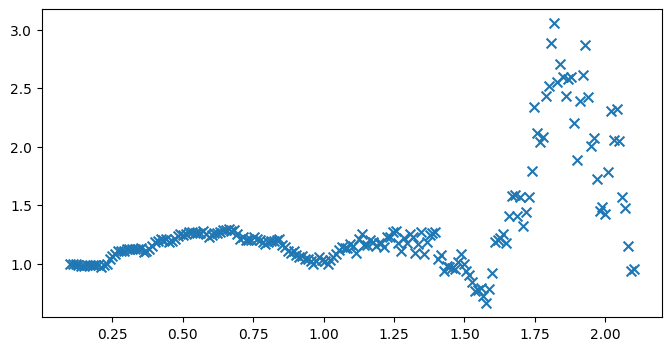

In [5]:
manual_seed(0)
train_dir = "./dump/"
train_dir = os.path.join(train_dir, "synthetic")
ckpt_dir = os.path.join(train_dir, "ckpts")
os.makedirs(ckpt_dir, exist_ok=True)
ts, ts_ext, ys, ht = get_data()

ts_, ys_ = ts, ys
ht = ht.squeeze()

ts, ys = ts.to("cpu"), ys.to("cpu")[:, None]
plt.figure(figsize=(8, 4))
plt.scatter(ts_, ys_, marker="x", s=50)
mpl.pyplot.show()

In [6]:
train_dir = "./dump/"
adjoint = False
train_iters = 3000
kl_anneal_iters = 100
likelihood_cls = distributions.Normal
scale = 0.025
method = "euler"
dt = 5 * 1e-3
batch_size = 1024
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
manual_seed(seed)

model = FIM(batch_size = batch_size).to(device)
sdeint_fn = torchsde.sdeint_adjoint if adjoint else torchsde.sdeint
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
kl_scheduler = LinearScheduler(iters=kl_anneal_iters)

# for visualization
vis_batch_size = 1024
ts_vis = torch.linspace(ts_ext[0], ts_ext[-1], 300).to(device)
eps = torch.randn(vis_batch_size, 1).to(device)
bm_vis = torchsde.BrownianInterval(
    t0=ts_ext[0],
    t1=ts_ext[-1],
    size=(vis_batch_size, 1),
    device=device,
    levy_area_approximation="space-time",
)

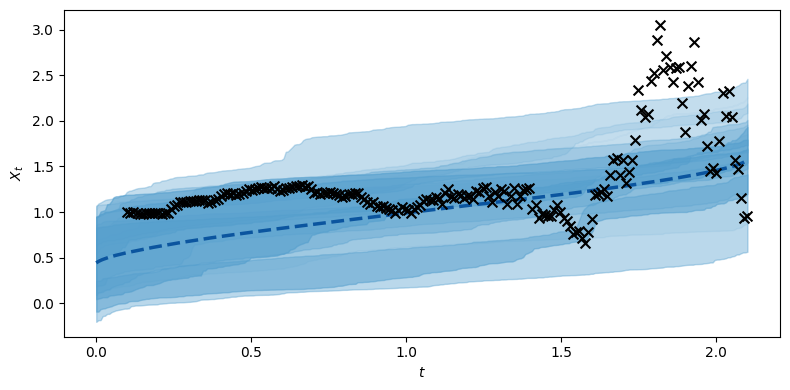

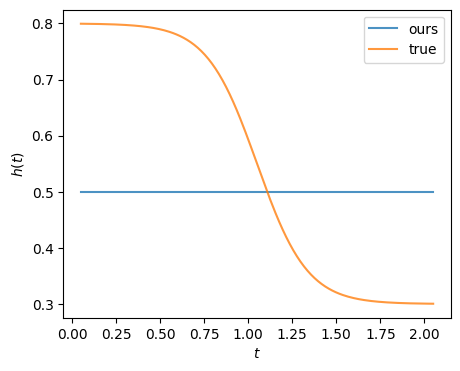

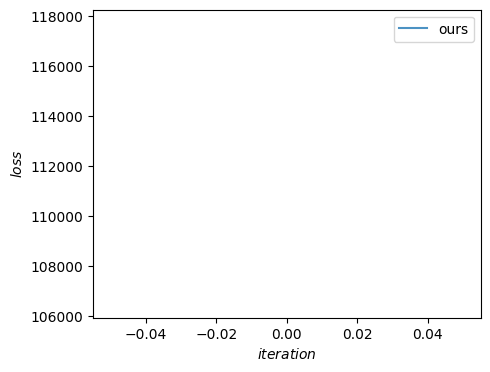

Iter: 0 	logpy: -112104.180 	kl: 1.615 	loss: 112104.195


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [7]:
# training loop
loss_graph = []
iter_graph = []
for i in range(train_iters):
    if i % 100 == 0:
        plot_posterior(
            model.sample_q,
            ts=ts_,
            ys=ys_,
            ts_vis=ts_vis,
            batch_size=vis_batch_size,
            sdeint_fn=sdeint_fn,
            bm=bm_vis,
            eps=eps,
            method=method,
            dt=dt,
        )
        plot_h(model.compute_hurst, ts, ts_, ht)
        plt.show()
        plt.close()

    optimizer.zero_grad()
    zs, kl = model(
        ts=ts, batch_size=batch_size, sdeint_fn=sdeint_fn, method=method, dt=dt, bm = None
    )
    zs = zs.squeeze()
    zs = zs[1:-1]

    likelihood = likelihood_cls(loc=zs, scale=scale)
    logpy = likelihood.log_prob(ys[1:-1]).sum(dim=0).mean(dim=0)

    loss = kl * kl_scheduler.val - logpy #torch.sqrt((ys[1:-1]-zs)**2).mean()
    loss.backward()
    loss_graph.append(loss.cpu().detach().cpu().numpy())
    iter_graph.append(i)

    optimizer.step()
    scheduler.step()
    kl_scheduler.step()
    if i % 100 == 0:
        plot_loss(loss_graph, iter_graph)
        plt.show()
        print(
            f"Iter: {i} \t"
            f"logpy: {logpy.detach().cpu().numpy():.3f} \t"
            f"kl: {kl.cpu().detach().cpu().numpy():.3f} \t"
            f"loss: {loss.cpu().detach().cpu().numpy():.3f}"
        )

In [ ]:
import torchviz
# torchviz.make_dot(zs.mean(), params=dict(model.named_parameters()))

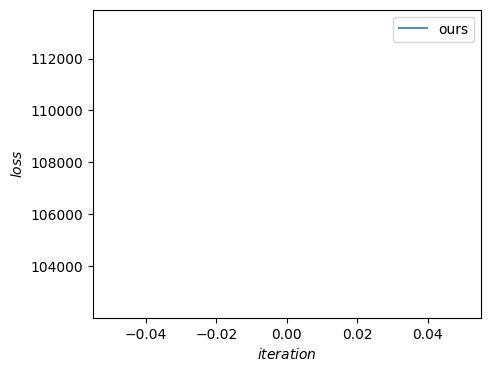

In [8]:
# !conda install python-graphviz -y
plot_loss(loss_graph, iter_graph)
plt.show()

In [9]:
model.prob_IH.shape

torch.Size([1024, 1])

In [ ]:
plot_h(model.compute_hurst, ts, ts_, ht)

In [ ]:
model.hurst_net(torch.tensor([1.,1.,1.]))

In [ ]:
[p for p in model.hurst_net.parameters()]

In [ ]:
bm = torchsde.BrownianInterval(
        t0=ts[0],
        t1=ts[-1],
        size=(batch_size, 1))
bm

In [8]:
import torchview
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')
model_graph = draw_graph(model, input_data = (ts[0:1], 1, sdeint_fn, "euler", dt), expand_nested=True)
graph = model_graph.visual_graph

RuntimeError: Failed to run torchgraph see error message

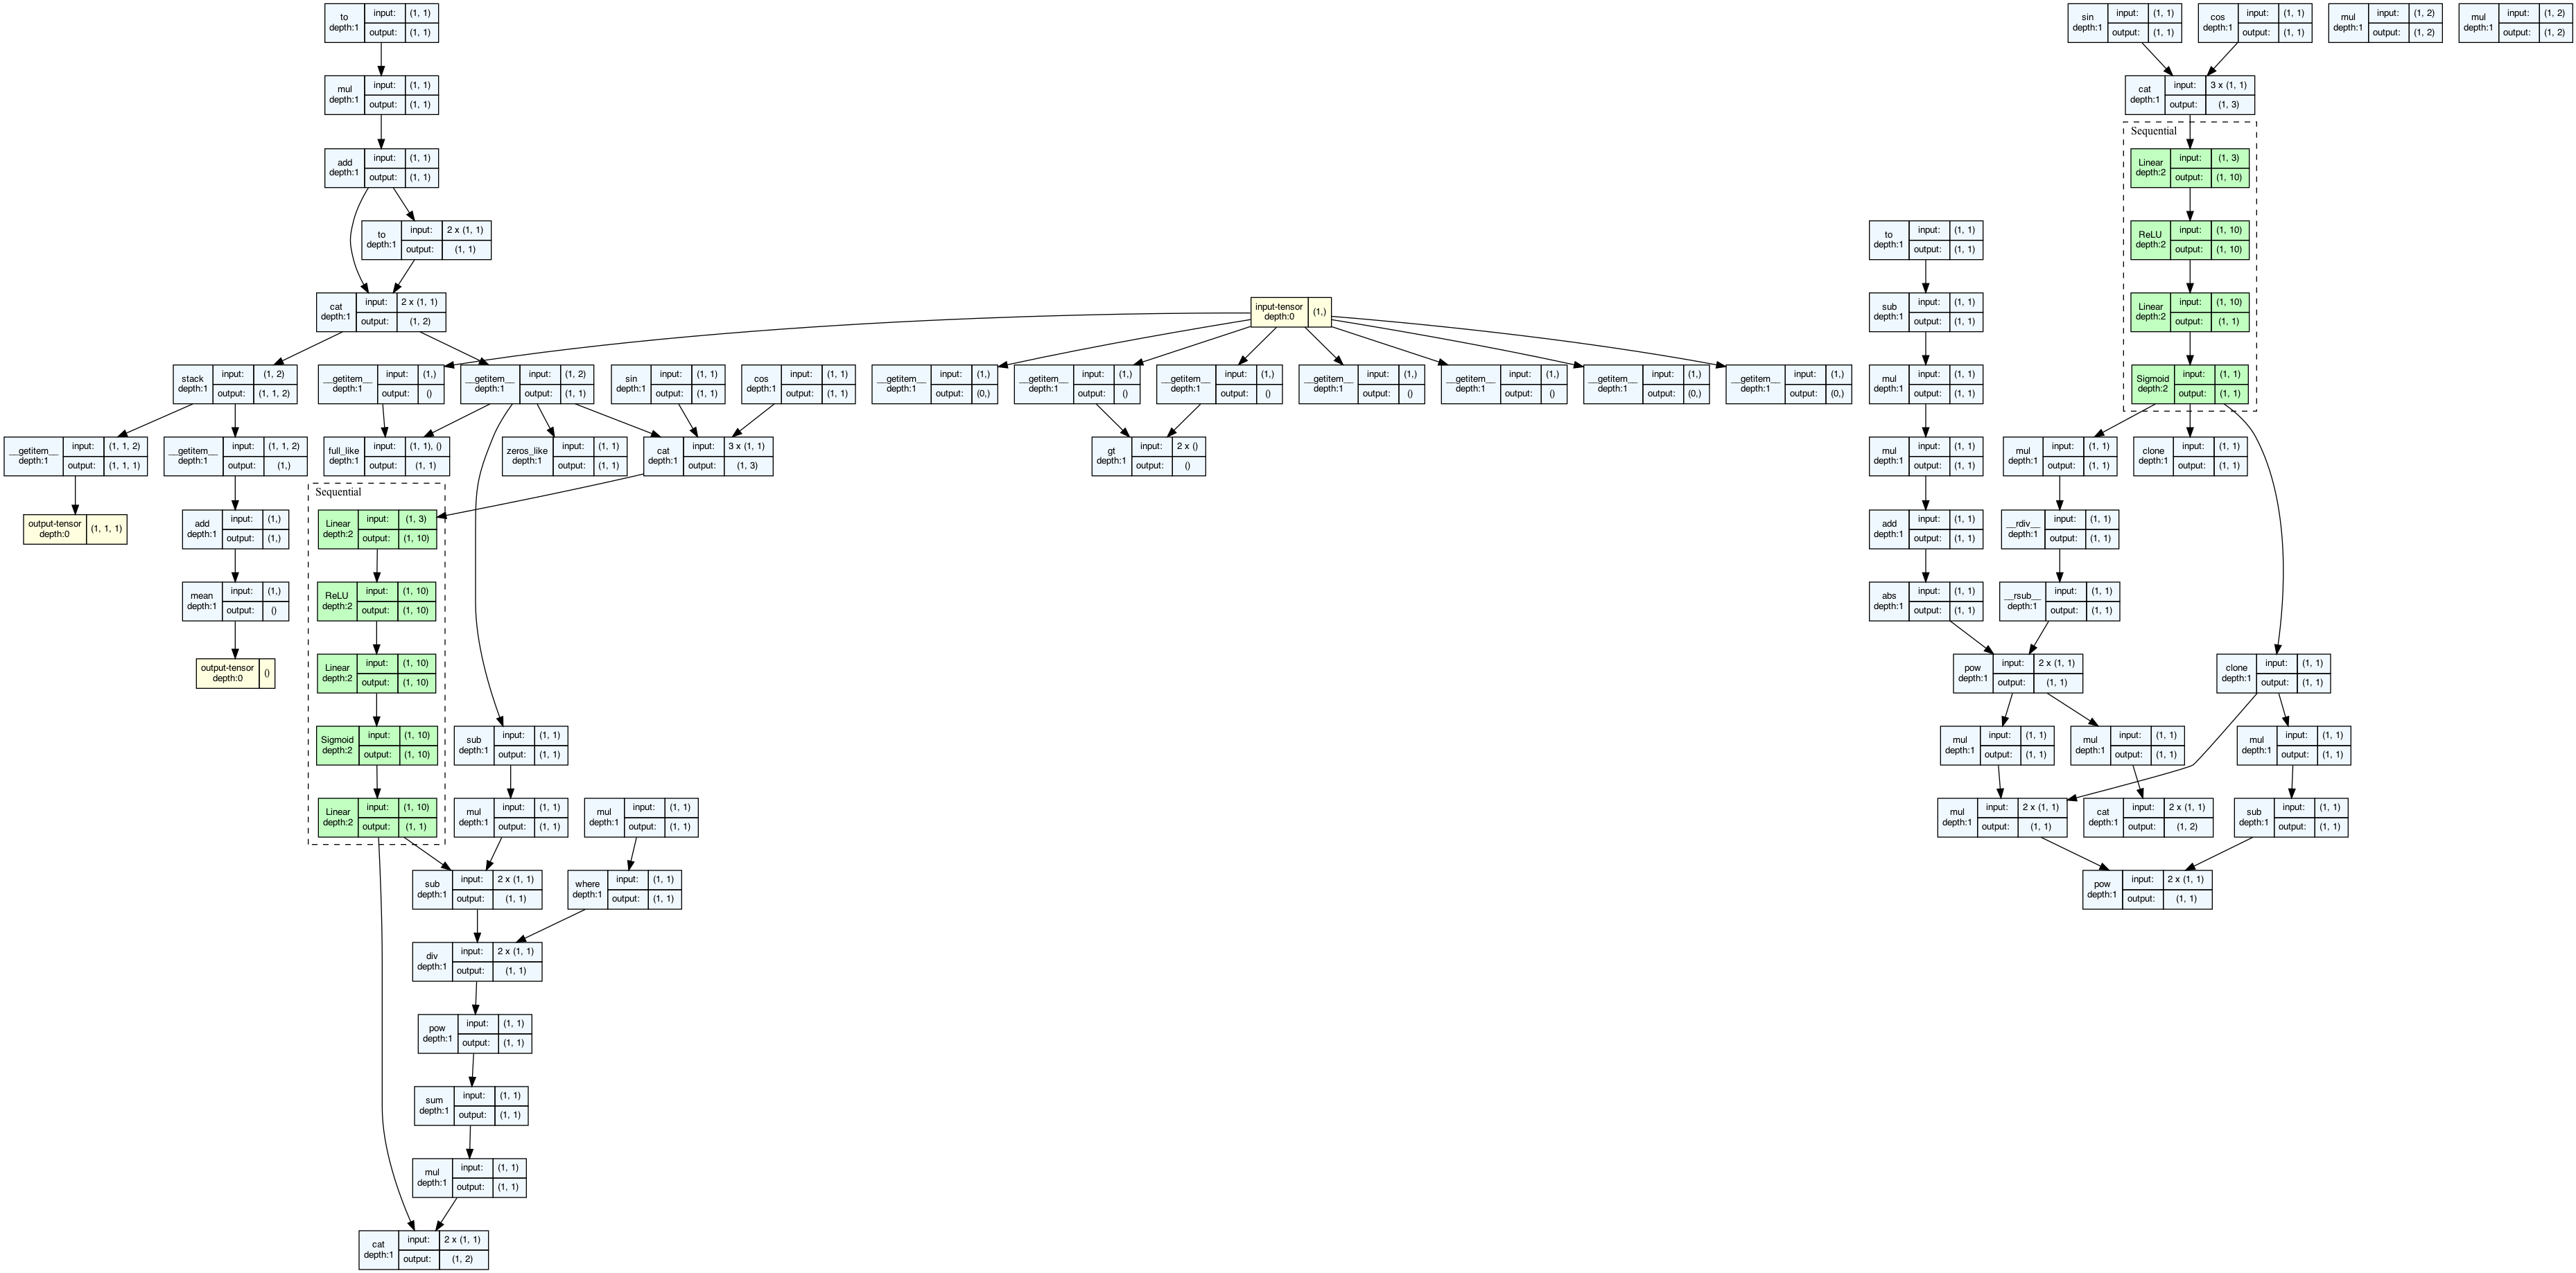

In [11]:
graph